In [2]:
# Standard libraries
import numpy as np
import pandas as pd

# Deep learning libraries
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Project specific libraries
from data.dataset import CarDataset
from pipeline.preprocessing import PreprocessingPipeline, PreprocessingPipelineBinary, PreprocessingPipelineCutOff

# Visualization libraries
import matplotlib.pyplot as plt

# Evaluation libraries
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [3]:
# Load data

X = np.load("data/numpy/images.npy")
Y = np.load("data/numpy/labels.npy")

print(X.shape)
print(Y.shape)

(4000, 506, 674, 3)
(4000, 2)


# Regression on full dataset, both scores

In [4]:
# Create the preprocessing pipeline
pipeline = PreprocessingPipeline(output_size=(224, 224), normalize=True, discretize=False)

# Create the dataset
dataset = CarDataset(X, Y, transform=pipeline, discretize=False)

# Create the data split, training and validation
generator = torch.Generator().manual_seed(42)   
X_train, X_test = random_split(dataset, [0.8, 0.2], generator=generator)

# Create the dataloader
train_dataloader = DataLoader(X_train, batch_size=8, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=8, shuffle=True)

In [5]:
# Specify model, loss function and optimizer

from models.regression_model import SimpleCNN

regression_model = SimpleCNN()

criterion = nn.MSELoss()

optimizer = optim.Adam(regression_model.parameters(), lr=0.001)

In [6]:
# Train and evaluate model

regression_model.train_model(epochs=2, train_loader=train_dataloader, criterion=criterion, optimizer=optimizer, device="cpu")

regression_model.evaluate_model(val_loader=test_dataloader, criterion=criterion, device="cpu")

Training Loss: 2926.6835
Training Loss: 0.1742
Validation Loss: 0.1169


# Binary classification with one model for each score - full dataset

In [7]:
# Create the preprocessing pipeline
pipeline = PreprocessingPipelineCutOff(output_size=(224, 224), normalize=True)

# Create the dataset
dataset = CarDataset(X, Y[:, 0], transform=pipeline, discretize=False)

# Create the data split
generator = torch.Generator().manual_seed(42)
X_train, X_test = random_split(dataset, [0.8, 0.2], generator=generator)

# Create the dataloader
train_dataloader = DataLoader(X_train, batch_size=8, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=8, shuffle=True)

In [8]:
# Specify model, loss function and optimizer

from models.binary_model import SimpleCNNBinary

binary_model = SimpleCNNBinary(num_classes=1)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

In [9]:
# Train and evaluate model

binary_model.train_model(train_loader=train_dataloader, criterion=criterion, optimizer=optimizer, device="cpu")

y_true, y_pred = binary_model.evaluate_model(val_loader=test_dataloader, criterion=criterion, device="cpu")

Training Loss: 7.3743 | Accuracy: 0.7312
Validation Loss: 0.6221 | Accuracy: 0.8263


F1 Score: 0.6819221967963386
Precision: 0.7801047120418848
Recall: 0.6056910569105691
AUC: 0.7649393912711691


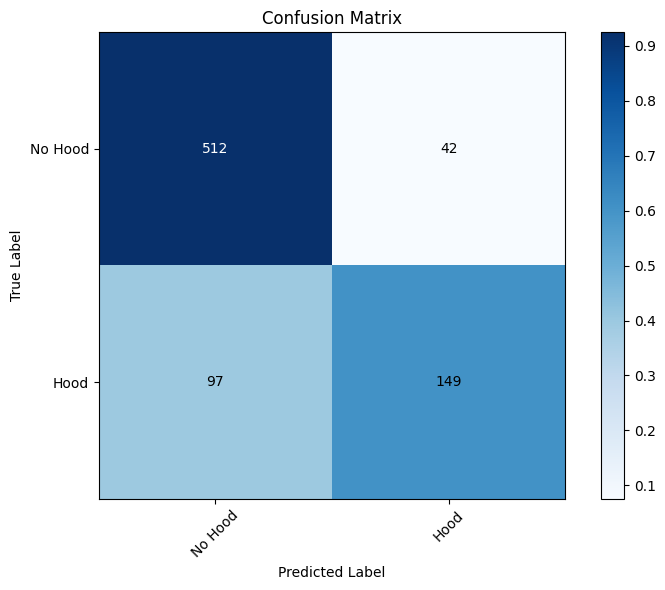

In [10]:
# Print some classification metrics

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

classes = ["No Hood", "Hood"]

# Plot confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))  # Adjust figure size as needed 
plt.imshow(cf_matrix_norm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
  for j in range(len(classes)):
    plt.text(j, i, cf_matrix[i, j], ha="center", va="center", color="white" if cf_matrix[i, j] > cf_matrix.mean() else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Binary classification with one model for each score - undersampled data

In [20]:
# Load undersampled data

X = np.load("data/numpy_undersampled/X_data.npy")
Y = np.load("data/numpy_undersampled/Y_labels.npy")

print(X.shape)
print(Y.shape)

(2482, 506, 674, 3)
(2482,)


In [21]:
# Create the preprocessing pipeline
pipeline = PreprocessingPipelineBinary(output_size=(224, 224), normalize=True)

# Create the dataset
dataset = CarDataset(X, Y, transform=pipeline, discretize=False)

# Create the data split
generator = torch.Generator().manual_seed(42)
X_train, X_test = random_split(dataset, [0.8, 0.2], generator=generator)

# Create the dataloader
train_dataloader = DataLoader(X_train, batch_size=8, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=8, shuffle=True)

In [22]:
# Specify model, loss function and optimizer

from models.binary_model import SimpleCNNBinary

binary_model = SimpleCNNBinary(num_classes=1)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

In [23]:
# Train and evaluate model

binary_model.train_model(train_loader=train_dataloader, criterion=criterion, optimizer=optimizer, device="cpu")

y_true, y_pred = binary_model.evaluate_model(val_loader=test_dataloader, criterion=criterion, device="cpu")

Training Loss: 8.6244 | Accuracy: 0.6143
Validation Loss: 0.6687 | Accuracy: 0.6230


F1 Score: 0.626746506986028
Precision: 0.628
Recall: 0.6254980079681275
AUC: 0.6229530856167168


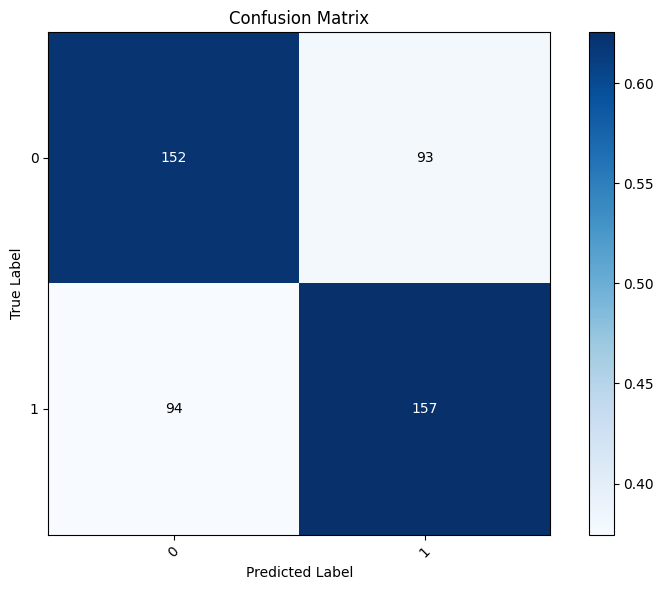

In [24]:
# Print some classification metrics

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))  # Adjust figure size as needed 
plt.imshow(cf_matrix_norm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
  for j in range(len(classes)):
    plt.text(j, i, cf_matrix[i, j], ha="center", va="center", color="white" if cf_matrix[i, j] > cf_matrix.mean() else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Binary Classification with pretrained Vision Transformer - undersampled data

In [16]:
# Specify model, loss function and optimizer

from transformers import ViTForImageClassification, ViTFeatureExtractor

model_name = "google/vit-base-patch16-224-in21k"  # Example model name
model = ViTForImageClassification.from_pretrained(model_name, num_labels=1)
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss function
criterion = torch.nn.BCEWithLogitsLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Train model

from src.helpers import train_model, evaluate_model

train_model(model, train_dataloader,criterion, optimizer, num_epochs=1)
y_true, y_pred = evaluate_model(model, test_dataloader, criterion)


Epoch [1/1] - Training Loss: 0.6998 | Accuracy: 0.5045
Validation Loss: 0.7086 | Accuracy: 0.4940


F1 Score: 0.0
Precision: 0.0
Recall: 0.0
AUC: 0.5


/Users/moritzwendhausen/miniconda3/envs/AI_Env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


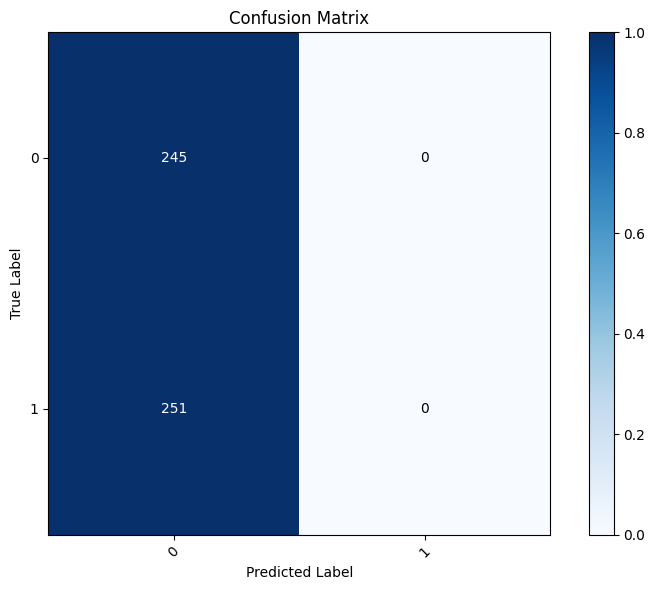

In [19]:
# Print some classification metrics

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))  # Adjust figure size as needed 
plt.imshow(cf_matrix_norm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
  for j in range(len(classes)):
    plt.text(j, i, cf_matrix[i, j], ha="center", va="center", color="white" if cf_matrix[i, j] > cf_matrix.mean() else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()